# **Lab 4**

### Question:
#### Write a python program to build a neural network model ( with 1-2-1 layer architecture ) with backpropagation training algorithm to approximate a function 

$g(p) = sin(\frac{π}4 × p)$

Where, $ -2 ≤ p ≤ 2 $

#### Transfer function for layer 1: Log-sigmoidal

#### Transfer function for layer 2: Pure-limit

#### Learnign Rate: 0.1

#### Try changing architucture of the network and learning rate to demonstrate the changes of Mean Square Error w.r.t Epoch for the Nural Network.



### Solution:

In [62]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *

In [63]:
# Net Calculation
def Z_op(X,W,B):
    Z = np.dot(X,W.T) + B
    return Z

# Actual Output Calculation
def Y_op(Tf,Z):
    Yout = []
    for z in Z:
        y = Tf(z)
        Yout.append(y)
    return np.array(Yout)
    
# Error Calculation
def Cost(Y,T):
    errors = T - Y
    # Sum of sq err
    SSE = 0
    for error in errors:
        SSE = SSE + error*error
    # Mean sq err
    MSE = SSE/len(errors)
    return MSE

### Froward propagation:

${\bf a^{m + 1} = f^{m+1} ( W^{m+1} a^m + b^{m+1})}$

#### For $ m = 0,1,...,M-1 $

#### Where,

#### $f^{i}$ is transfer function of $i$ th layer

#### $a^{i}$ is actual output of $i$ th layer

#### $W^{i}$ is weight matrix of $i$ th layer

#### $b^{i}$ is bias of $i$ th layer

In [64]:
def feed_forward(W,B,X,Tf_list):
    Z_list = []
    X_list = []
    X_list.append(X)
    for i,j,k in zip(range(len(W)),range(len(B)),range(len(Tf_list))):
        z = Z_op(X,W[i],B[j])
        Z_list.append(z)
        # Using Transfer Function from the TF list 
        y = Y_op(Tf_list[k],z)
        # Equating actual output to next neuron input
        X = y
        X_list.append(X)
    # Return actual output and net
    return Z_list,X_list

### Sensivity:

#### The sensivity index represents,

$S^m ≡ {\bf \frac{∂F̂}{∂n^m}} = \begin{bmatrix}
\frac{∂F̂}{∂n_1^m}\\
\frac{∂F̂}{∂n_2^m}\\
.\\
.\\
.\\
\frac{∂F̂}{∂n_{S^m}^m}
\end{bmatrix}$

#### Sensivity index for all the layer except last layer, ( i.e. backpropagating through sensitivities ):
$S^m = {\bf Ḟ^m(n^m)(W^{m+1})^{\it T}s^{m+1}}$

#### Sensivity of last layer:
$S^M = -2 {\bf Ḟ^M(n^M)(t - a)}$

#### Where,

${\bf Ḟ^m(n^m)} = \begin{bmatrix}
ḟ^m(n_1^m) & 0 & ... & 0\\
0 & ḟ^m(n_2^m) & ... & 0\\
. & . &  & .\\
. & . &  & .\\
0 & 0 & ... & ḟ^m(n_{S^m}^m)
\end{bmatrix}$

#### here,

$ḟ^m(n_j^m) = \frac{∂f(n_j^m)}{∂n_j^m}$

#### i.e. derivative of transfer function,

#### and $n^i$ is $i$ th layer net output

In [65]:
def sensitivity(Z_list,X_list,F_prime,Target,Weights):
    F_list = []
    Sn_list = []
    # To change the shape of vector from (n,) -> (n,1)
    def reverse_reshaping(vector):
      if vector.shape == (len(vector),):
        return vector.reshape(len(vector),1)
      else :
        return vector
    for i in range(len(Z_list)):
      # F dot diagonal matrics calculation
        D = []
        for k in Z_list[i]:
            d = F_prime[i](k)
            D.append(d)
        Dag = np.array(D)
        F_dot = np.diag(Dag)
        F_list.append(F_dot)
    # Assigning F_n to last layer F dot value
    F_n = F_list.pop(len(F_list)-1)
    A_n = X_list.pop(len(X_list)-1)
    # Calculation of Error for calculation of last layer senditivity
    error = Target - A_n
    # Calculation of sensitivity of last layer of neural network
    S_n = np.array(-2*np.dot(F_n,error.T))
    Sn_list.append(S_n)
    # Calculation of previous layer sensitivities
    for i in range(len(F_list),0,-1):
        # F_dot_W = multiplication of Fn and Wn+1 transpose
        F_dot_W = np.array(np.dot(F_list[i-1],Weights[i].T))
        S_n = np.dot(reverse_reshaping(F_dot_W),reverse_reshaping(S_n))
        Sn_list.append(S_n.T)
    # Return List of Sensitivity indices
    return Sn_list


### Weight and Bias updation:

${\bf W^m}(k + 1) = {\bf W^m} (k) - α {\bf s^m (a^{m-1})^{\it T}}$

${\bf b^m}(k + 1) = {\bf b^m} (k) - α {\bf s^m }$

#### Where, $k$ is the epoch and $α$ is the learning rate

In [92]:
def weight_bias_updation(Weight,Bias,Alpha,Sensitivity,X_List):
    new_weights = []
    new_bias = []
    # To change the vector shape from (n,1) -> (n,)
    def reshaping(vector):
      if type(vector[0]) == np.float64:
        return vector
      else:
        if vector.shape == (len(vector),1):
          return vector.reshape(len(vector),)
        elif vector.shape == (1,len(vector[0])):
          return vector.reshape(len(vector[0]),)
        else :
          return vector
    # To change the shape of vector from (n,) -> (n,1)
    def reverse_reshaping(vector):
      if type(vector) == float:
        return vector
      else:
        if vector.shape == ():
          return vector.reshape(1,1)
        elif vector.shape == (len(vector),):
          return vector.reshape(len(vector),1)
        else :
          return vector
    # Reversing the Sensitivity List
    def Reverse(lst):
        return [ele for ele in reversed(lst)]
    sens = Reverse(Sensitivity)
    # Weight Updation
    for i in range(len(Weight)):
        # Using reshapeing and reverse reshaping for safe check the (n,1) and (n,) cases
        delta_w = reshaping(Alpha*sens[i]*reverse_reshaping(X_List[i]))
        w = Weight[i] - delta_w.T #As a(1) = X[0], The loop will run for w[0],w[1]...w[n-1], which we will use as w1,w2...wn
        new_weights.append(w)
    # Bias Updation
    for i in range(len(Bias)):
        b = Bias[i] - reshaping(Alpha*sens[i].T)
        new_bias.append(b)
    return new_weights,new_bias

In [67]:
def Error_Collection(Target,Output,All_Errors):
  Error = Cost(Output,Target)
  All_Errors.append(Error)

In [68]:
def backpropagation(Weight,Bias,Pattern,Target,Alpha,Transfer_Function,F_Prime,Epoch):
  all_errors = []
  epoch_list = []
  # Loop through number of epochs
  for i in range(Epoch):
      # Feed Forward
      zl,xl = feed_forward(Weight,Bias,Pattern,Transfer_Function)
      actual_output = xl[len(xl)-1]
      # Error Calculation
      Error_Collection(Target,actual_output,all_errors)
      # Sensitivity
      sen = sensitivity(zl,xl,F_Prime,Target,Weight)
      # Weight Bias Updation
      Weight,Bias = weight_bias_updation(Weight,Bias,Alpha,sen,xl)
      epoch_list.append(i+1)
  # Plot Epoch vs MSE diagram
  plt.scatter(epoch_list,all_errors)
  plt.xlabel('Number of Epoch')
  plt.ylabel('Mean Square Error')
      

In [69]:
def input_velues():
  # Getting user input
  print('Enter number of layers :')
  num_layers = int(input())
  num_nurons = []
  Tf_list = []
  F_prime = []
  W = []
  B = []
  X = []
  T = []
  print('\n')
  for num in range(num_layers):
    print('Enter numbers of neurons in layer {number} :'.format(number = num))
    num_nuron = int(input())
    num_nurons.append(num_nuron)
  print('Enter mathametical expression with respect to variable x.\n The variable should be continous, differntiable and use the proper Latex notation for each expression.\n')
  for num in range(num_layers - 1):
    # Converting Tf expression into function
    f_exp = input('Enter Expression for transfer function of layer {number} :'.format(number = num + 1))
    x = Symbol('x')
    f = lambdify(x,f_exp)
    # Differentiation of the Given Function  
    f_prime_exp = diff(f_exp)
    f_prime = lambdify(x,f_prime_exp)
    # Appending to the Transfer function and Derivative of Tf list
    Tf_list.append(f)
    F_prime.append(f_prime)

  def reshaping(vector):
    # To change the vector shape from (n,1) -> (n,)
    if type(vector[0]) == np.float64:
      return vector
    else:
      if vector.shape == (len(vector),1):
        return vector.reshape(len(vector),)
      elif vector.shape == (1,len(vector[0])):
        return vector.reshape(len(vector[0]),)
      else :
        return vector
  # Generating the random weight and bias
  for i in range(len(num_nurons)-1):
    w = np.random.rand(num_nurons[i+1],num_nurons[i])
    b = np.random.rand(num_nurons[i+1])
    W.append(w)
    B.append(b)
  new_w = []
  new_b = []
  # Reshaping the weight and bias matrics
  for w in W:
    w = reshaping(w)
    new_w.append(w)
  for b in B:
    b = reshaping(b)
    new_b.append(b)
  W = new_w
  B = new_b
  print('\n')
  print('Enter the list of patterns:')
  # Converting input string to point the input variable present in the environment
  pattern_input = input()
  X = globals()[pattern_input]
  print('Enter the target:')
  # Converting input string to point the target variable present in the environment
  target_input = input()
  T = globals()[target_input]
  X = np.array(X)
  T = np.array(T)
  # Input of Learning Rate and Epoch
  alpha = float(input('Enter the learning rate :'))
  epoch = int(input('Enter the number of epoch :'))
  return W,B,Tf_list,F_prime,X,T,alpha,epoch


In [70]:
def main():
  # Getting the input
  W,B,Tf_list,F_prime,X,Target,alpha,epoch = input_velues()
  # Print initial Weight and Bias 
  print('\nInitial Weights:')
  print(W)
  print('\nInitial Biases:')
  print(B)
  print('\n')
  # Backpropagetion
  backpropagation(W,B,X,Target,alpha,Tf_list,F_prime,epoch)

### Input and Target of the Nural Network

In [71]:
def g(p):
  return 1 + np.sin(np.pi /4 * p)

In [97]:
inp = np.random.uniform(-2,2,)
inp

1.8846600863469622

In [98]:
out = g(inp)
out

1.9958997342973805

### Architecture of nural network:

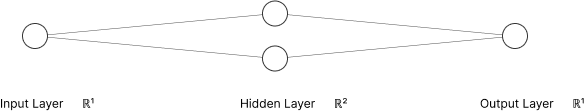

Enter number of layers :
3


Enter numbers of neurons in layer 0 :
1
Enter numbers of neurons in layer 1 :
2
Enter numbers of neurons in layer 2 :
1
Enter mathametical expression with respect to variable x.
 The variable should be continous, differntiable and use the proper Latex notation for each expression.

Enter Expression for transfer function of layer 1 :1/(1+exp(-x))
Enter Expression for transfer function of layer 2 :x


Enter the list of patterns:
inp
Enter the target:
out
Enter the learning rate :0.1
Enter the number of epoch :20

Initial Weights:
[array([0.10287018, 0.89164604]), array([0.15541074, 0.96535242])]

Initial Biases:
[array([0.8999683 , 0.22554195]), array([0.54766327])]




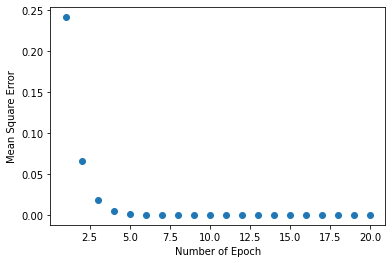

In [99]:
main()

### Other architecture of the network:

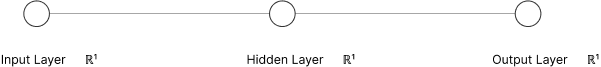

Enter number of layers :
3


Enter numbers of neurons in layer 0 :
1
Enter numbers of neurons in layer 1 :
1
Enter numbers of neurons in layer 2 :
1
Enter mathametical expression with respect to variable x.
 The variable should be continous, differntiable and use the proper Latex notation for each expression.

Enter Expression for transfer function of layer 1 :1/(1+exp(-x))
Enter Expression for transfer function of layer 2 :x


Enter the list of patterns:
inp
Enter the target:
out
Enter the learning rate :0.2
Enter the number of epoch :20

Initial Weights:
[array([0.68158676]), array([0.20736426])]

Initial Biases:
[array([0.79287951]), array([0.75262676])]




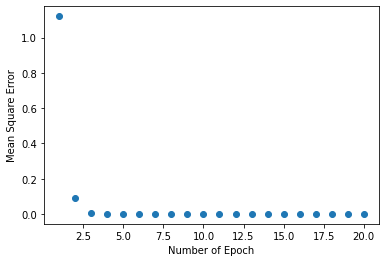

In [100]:
main()